# Analiza eksploracyjna

W skład danych wejściowych wchodzą sygnały biomedyczne EKG zebrane podczas badań na Wydziale Fizyki Politechniki Warszawskiej na dwóch osobach. Pomiary obejmują zarówno sygnał EKG rejestrowany **aparaturą kliniczną**, jak i nagrania z zegarka **Garmin Venu 3**. W przypadku drugiej osoby sygnał był pobierany zarówno w spoczynku, jak i podczas wysiłku fizycznego.

## Dane

### Dane z aparatury medycznej

W plikach CSV znajdują się sygnały EKG zarejestrowane aparaturą medyczną przy pomocy 12 odprowadzeń:
- 3 dwubiegunowe kończynowe Einthovena (**I**, **II**, **III**)
- 3 jednobiegunowe kończynowe wzmocnione Goldberga (**aVR**, **aVL**, **aVF**)
- 6 jednobiegunowych przedsercowych Wilsona (**V1**, **V2**, **V3**, **V4**, **V5**, **V6**)

Każde z odprowadzeń rejestruje sygnał EKG z częstotliwością próbkowania **500 Hz**.

Dla pierwszej badanej osoby (N36) liczba próbek to 66050 co daje około 2 minuty i 12 sekund nagrania, natomiast dla drugiej osoby (N38) liczba próbek to 625210 co daje około 20 minut i 50 sekund nagrania.

### Dane z zegarka Garmin Venu 3

Pobrane dane ze smartwatcha znajdują się w dwóch folderach:
- GARMIN-PDFs - zawiera pliki PDF z wykresami
- GARMIN-RECORDINGS - pliki JSON z próbkami sygnału i metadanymi

W **metadanych** możemy znaleźć informacje takie jak m.in:
- czas rozpoczęcia nagrania
- klasyfikację rytmu serca
- stronę przymocowania zegarka (lewa lub prawa ręka) - dla każdego z badanych osób zegarek był przymocowany do lewej ręki
- średnie tętno
- typ odprowadzenia - odczyt zegarka jest zbliżony do odprowadzenia I Einthovena
- częstotliwość próbkowania nagrania - **128 Hz**
- czas trwania nagrania - **30 sekund**

**Klasyfikacje** rytmu serca przyjmują następujące wartości:
- SINUS_NORMAL - prawidłowy rytm zatokowy
- INCONCLUSIVE_OTHER - rytm niejednoznaczny z powodu innych zakłóceń
- INCONCLUSIVE_POOR_SIGNAL - rytm niejednoznaczny z powodu słabej jakości sygnału
- INCONCLUSIVE_HR_OVER_120_50 - rytm niejednoznaczny z powodu zbyt wysokiego lub zbyt niskiego tętna
- INCONCLUSIVE_SR_WITH_HR_100_TO_120 - rytm niejednoznaczny z tętna w zakresie 100-120 bpm

Dla pierwszej osoby (N36) dostępne są 4 nagrania (łącznie 2 minuty) wykonane w spoczynku.
Dla drugiej osoby (N38) dostępnych jest 10 nagrań (łącznie 5 minut) obejmujących zarówno spoczynek, jak i wysiłek fizyczny.

In [1]:
# Przykładowy plik JSON
file = "data/N38/GARMIN-RECORDINGS/2025-11-14T11-18-10.0_151520bf-778f-4eb9-aecb-9b316d1c035b.json"
!head -n 26 $file
print("\t\t...")
!tail -n 9 $file

{
  "summary": {
    "detailId": "151520bf-778f-4eb9-aecb-9b316d1c035b",
    "startTime": 1763115490000,
    "startTimeLocal": "2025-11-14T11:18:10.0",
    "timeZoneOffsetInSeconds": 3600,
    "rhythmClassification": "SINUS_NORMAL",
    "mountingSide": "LEFT",
    "rmssdHrv": 86,
    "heartRateAverage": 87.0,
    "ecgAppVersion": "1.1.4",
    "udi": "(01)00860009117716(10)1.1.4",
    "symptoms": [],
    "deviceInfo": {
      "productName": "VENU3",
      "productId": 4260,
      "firmwareVersion": "17.01",
      "partNumber": "006-B4260-00"
    },
    "healthDeviceId": "18567240"
  },
  "reading": {
    "sampleRate": 128.0,
    "rawSampleRate": 512.0,
    "durationInSeconds": 30,
    "samples": [
		...
    ],
    "leadType": "Lead I"
  },
  "processingInfo": {
    "uploadTime": 1763115585555,
    "processingTime": 1763115585563,
    "apiVersion": "25.15.0"
  }
}

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import json

def plot_ecg(df, columns=None, start=None, end=None):
    """
    Wyświetla wykresy EKG.

    df      : DataFrame z danymi EKG
    columns : lista numerów kolumn lub nazwy kolumn do wyświetlenia (domyślnie wszystkie)
    start   : indeks początkowy fragmentu (domyślnie od początku)
    end     : indeks końcowy fragmentu (domyślnie do końca)
    """
    df_segment = df.iloc[start:end]

    if columns is None:
        cols_to_plot = df_segment.columns
    else:
        # jeśli podano numery kolumn
        if all(isinstance(c, int) for c in columns):
            cols_to_plot = df_segment.columns[columns]
        else:
            cols_to_plot = columns

    for col in cols_to_plot:
        plt.figure(figsize=(12, 3))
        plt.plot(df_segment[col])
        plt.title(f"EKG - odprowadzenie {col}")
        plt.xlabel("Próbka")
        plt.ylabel("Amplituda")
        plt.grid(True)
        plt.show()

def load_ecg_samples(path: str) -> pd.DataFrame:
    """
    Pobiera próbki z pliku JSON zegarka Garmin.

    path : ścieżka do pliku JSON
    """
    with open(path, "r") as f:
        data = json.load(f)

    try:
        samples = data["reading"]["samples"]
    except (TypeError, KeyError) as e:
        raise KeyError("Expected JSON structure with keys 'reading' -> 'samples'") from e

    if not isinstance(samples, (list, tuple)):
        raise ValueError("`reading.samples` must be a list or tuple of sample values")

    return pd.DataFrame(list(samples))

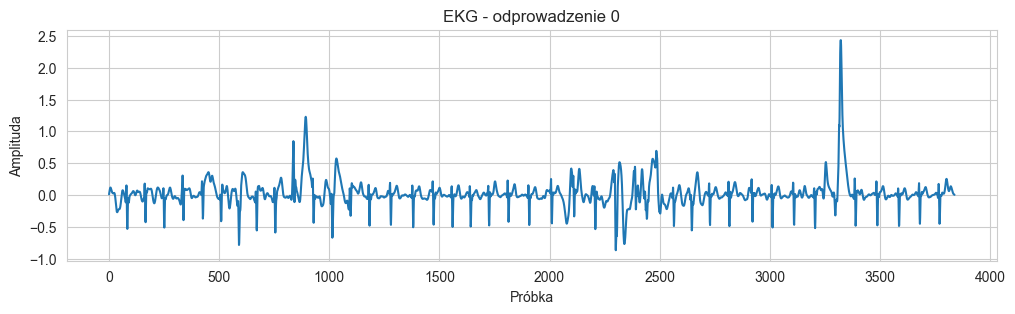

In [3]:
plot_ecg(load_ecg_samples(file))

In [4]:
# Przykładowy plik PDF
from IPython.display import IFrame
IFrame("data/N38/GARMIN-PDFs/Garmin_ECGRecording_11142025_0910PM.pdf", width=800, height=600)

Obserwujemy, że dane w plikach json rzeczywiście przedstawiają ten sam sygnał co wizualizacje w plikach pdf.

Pomiary z zegarka wykonywano równocześnie z rejestracją EKG aparaturą medyczną. Metadane zawierają informacje pozwalające dokładnie porównać oba sygnały w tych samych momentach czasu.

## Obraz EKG

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/3a/EKG_Komplex_PL.svg/960px-EKG_Komplex_PL.svg.png" width="400" alt="EKG kompleks" />

Na wykresie EKG można zaobserwować:
- **linię izoelektryczną** - linia pozioma zarejestrowana w czasie, gdy w sercu nie stwierdza się żadnych pobudzeń
- **załamki** - wychylenia od linii izoelektrycznej
- **odcinki** - czas trwania linii izoelektrycznej pomiędzy załamkami
- **odstępy** - łączny czas trwania odcinków i sąsiadującego załamka

### Załamki

- **załamek P** - jest wyrazem depolaryzacji mięśnia przedsionków (dodatni we wszystkich 11 odprowadzeniach, poza aVR, gdzie jest ujemny)
- **zespół QRS** - dpowiada depolaryzacji mięśnia komór (w tym czasie następuje również repolaryzacja przedsionków, którą przysłania zespół QRS), składa się z załamków Q, R i S
- **załamek T** - odpowiada repolaryzacji komór
- czasami też **załamek U** - odpowiada później repolaryzacji mięśni brodawkowatych

### Odcinki
- **odcinek PQ** - wyraża czas przewodzenia depolaryzacji przez węzeł przedsionkowo-komorowy
- **odcinek ST** - okres początkowej repolaryzacji mięśnia komór

### Odstępy
- **odstęp PQ** - wyraża czas przewodzenia depolaryzacji przez cały układ bodźcoprzewodzący serca
- **odstęp ST** - wyraża czas wolnej i szybkiej repolaryzacji mięśnia komór
- **odstęp QT** - wyraża czas potencjału czynnościowego mięśnia komór

Źródło: [Wikipedia – Elektrokardiografia](https://pl.wikipedia.org/wiki/Elektrokardiografia)

## Zakłócenia

W odczytach z obu urządzeń można znaleźć nietypowe fragmenty sygnałów, które wskazują na zakłócenia.
Najczęściej opisywanymi anomaliami EKG w literaturze są:
- **dryf linii bazowej** - przesuniecie linii izoelektrycznej w górę lub w dół, spowodowane oddychaniem, ruchem badanego, zmianą impedancji skóry-elektrody lub mikroprzesunięciami elektrod
- **zakłócenia sieciowe** - najczęściej sinusoidalny sygnał 50 lub 60 Hz, podchodzące z pola elektromagnetycznego linii zasilających, złego uziemienia aparatury i pętli przewodów
- **szumy mięśniowe** - pochodzą z aktywności mięśni, gdy badany się porusza lub drży
- **artefakty ruchowe** - wynikają z niesolidnego kontaktu elektrody ze skórą, ich przesuniecia i ruchu badanego
- **biały szum** - np. w przypadku słabego przesyłu czy bezpiecznej izolacji

### Przykłady zakłóceń w sygnale z aparatury medycznej
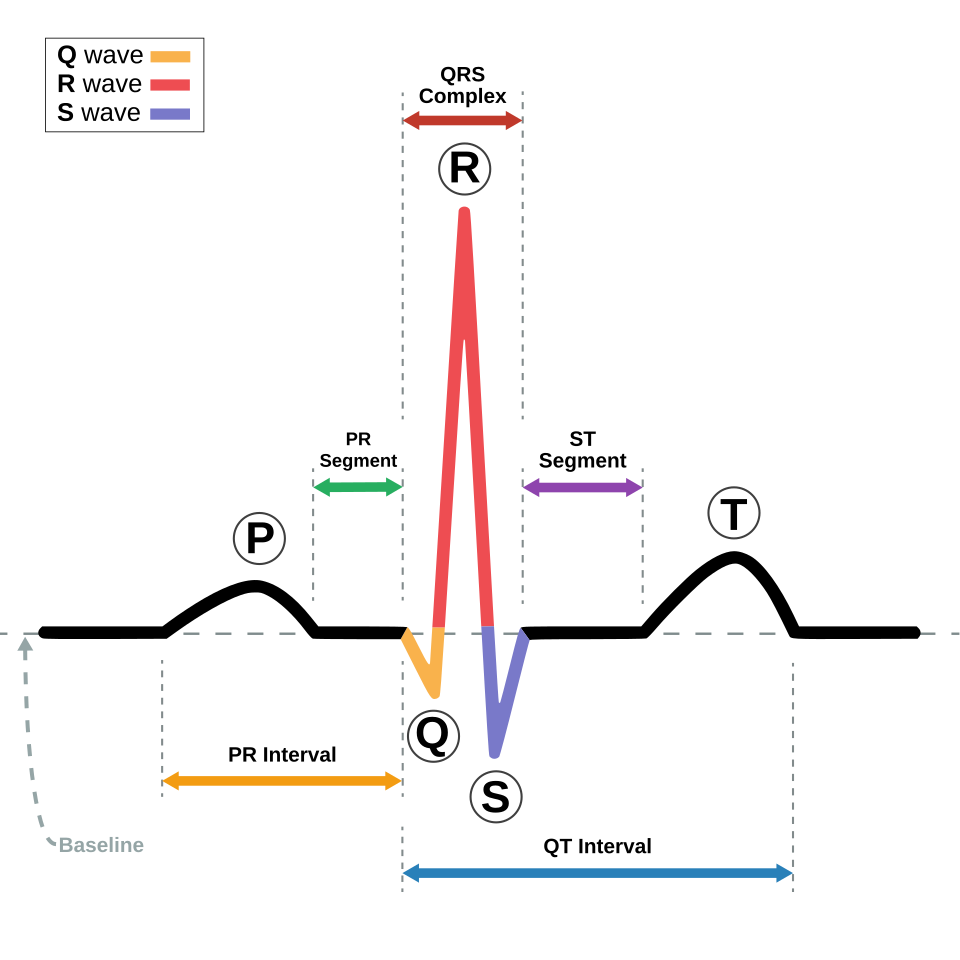
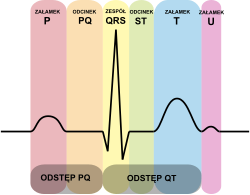

Dla danych pobranych pierwszego badanego (N36) możemy zauważyć anomalie m.in. pod koniec pomiarów w okolicach 63000 próbki, gdzie jest to szczególnie widoczne dla odprowadzenia V2, gdzie amplituda waha się znacząco.

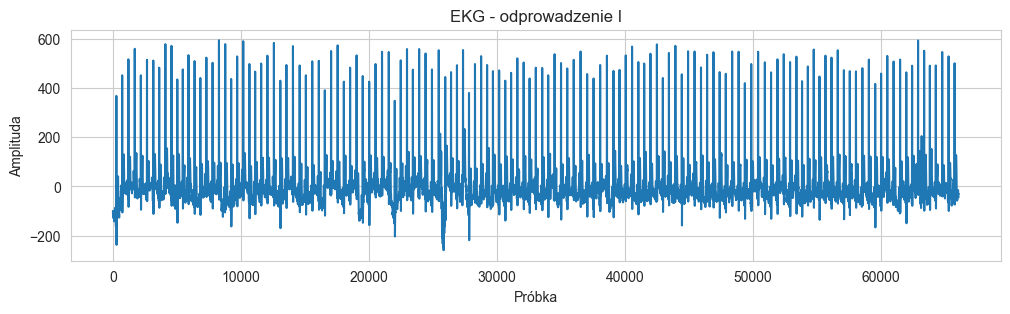

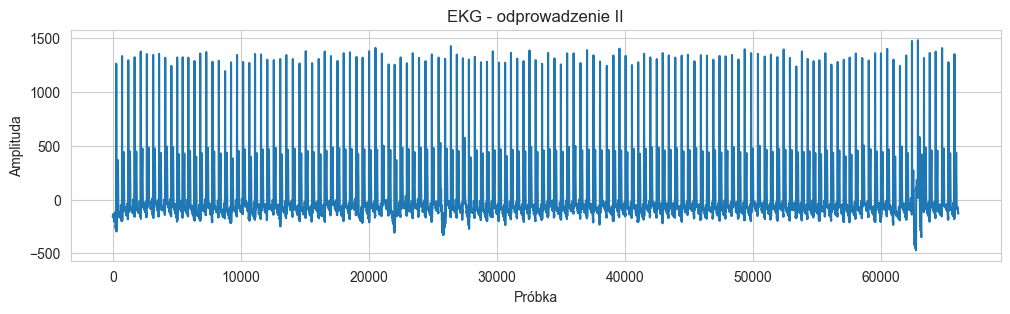

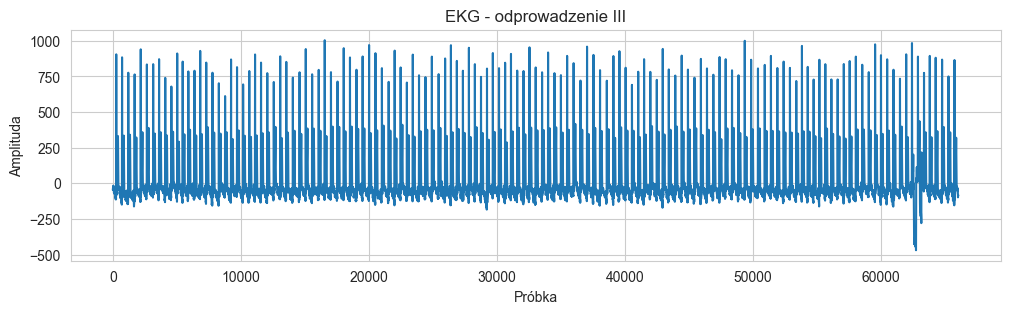

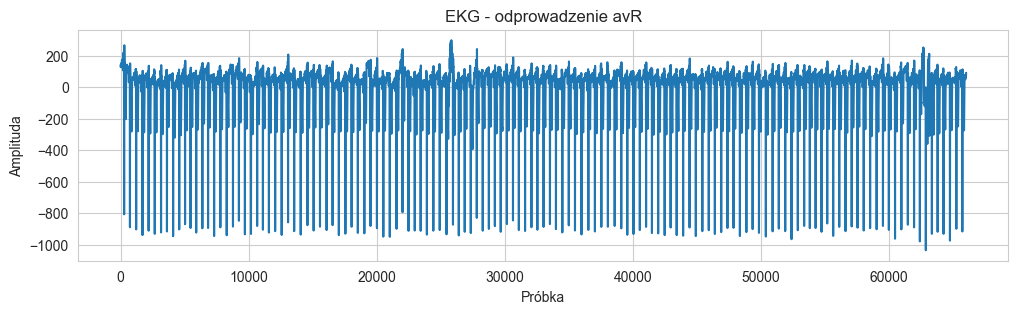

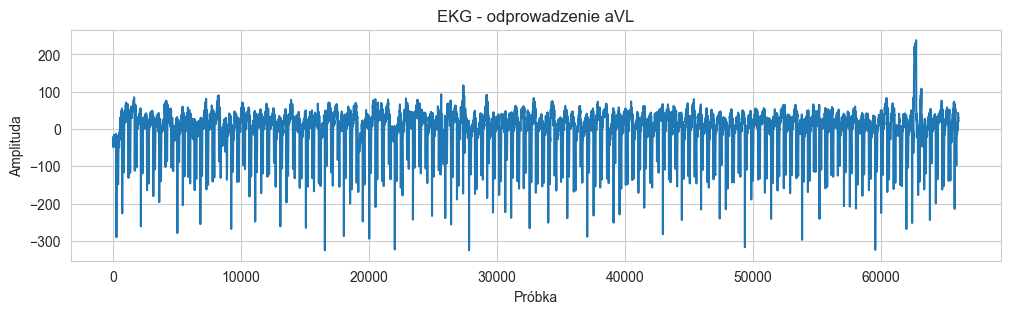

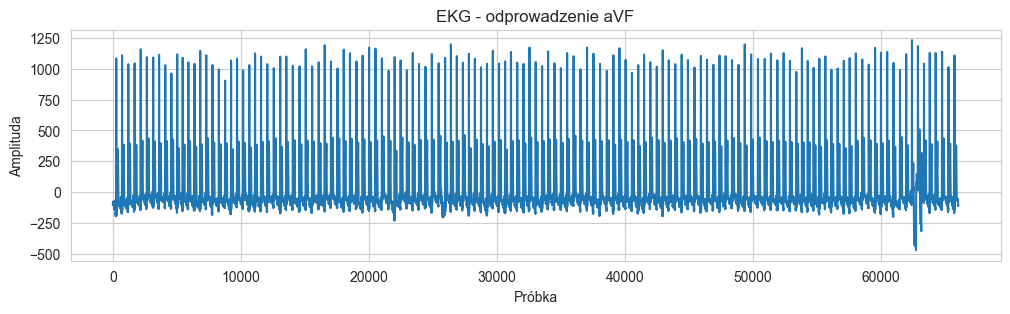

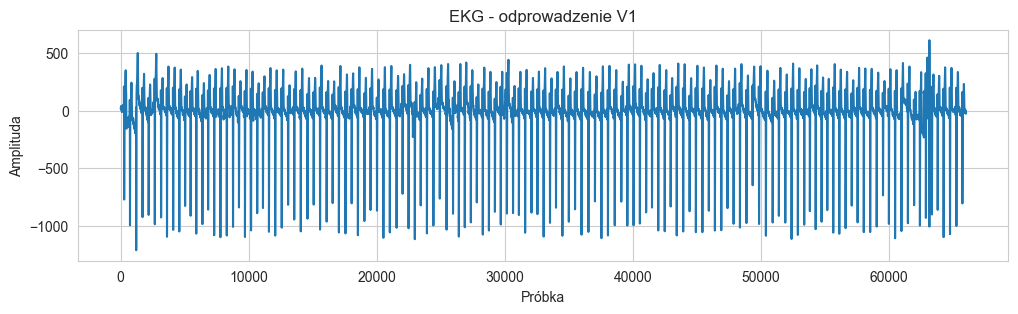

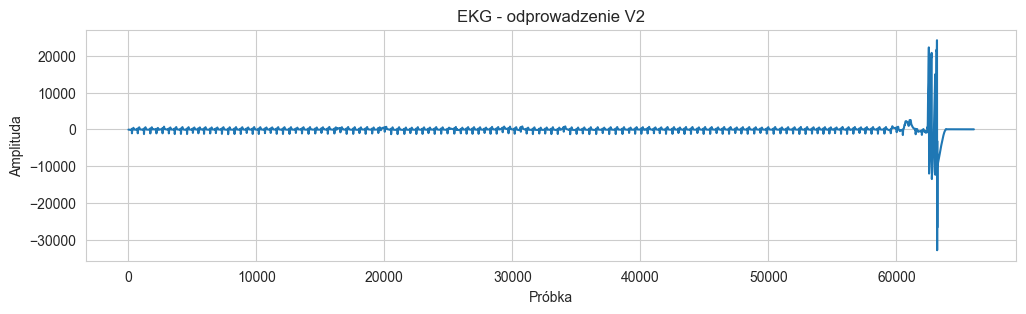

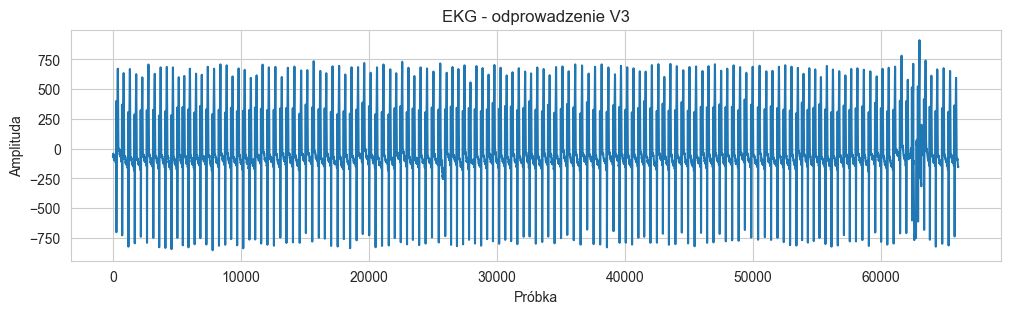

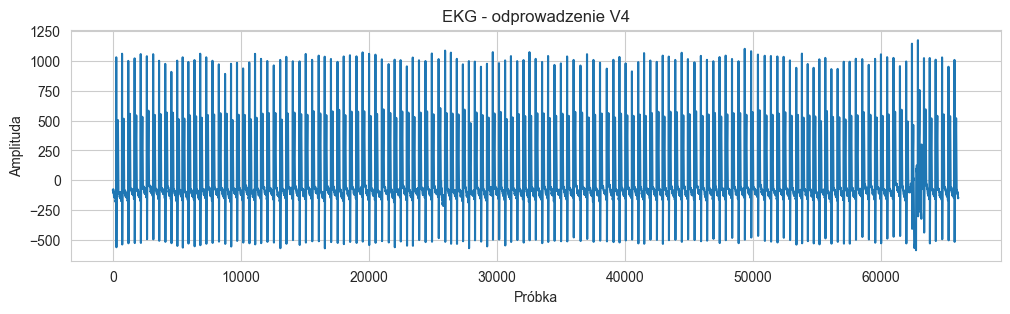

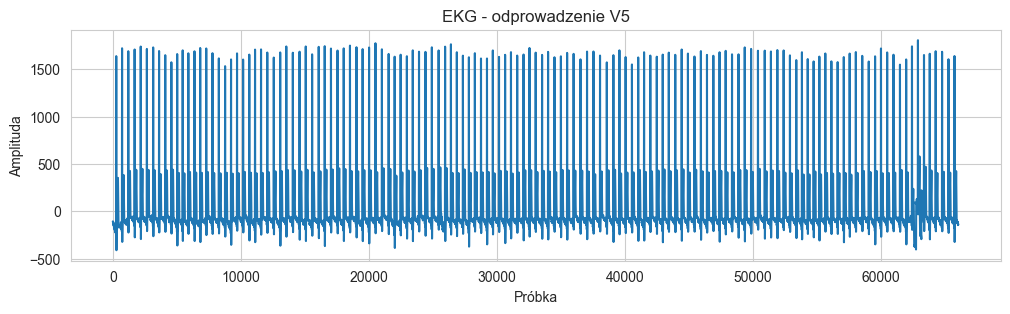

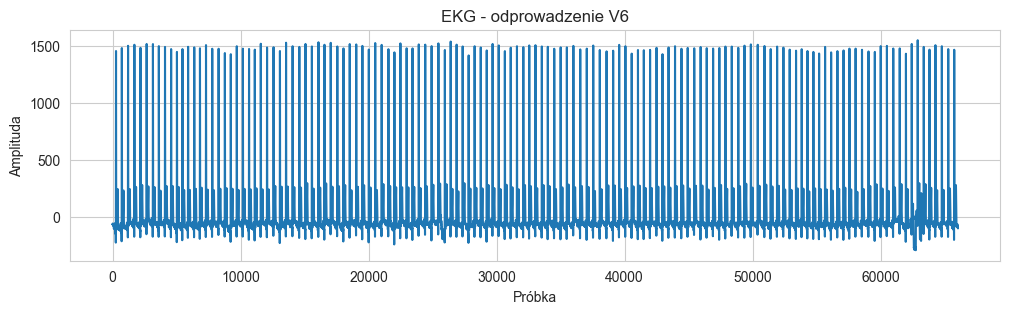

In [5]:
df = pd.read_csv("data/N36/N36_2025-EKG-2025-11-14-09-48-38.csv")
plot_ecg(df)

Jeszcze większe skoki sygnału, wskazujące na anomalie, możemy zauważyć dla danych drugiej osoby (N38). Dla większości odprowadzeń widzimy zakłócenia w przedziale 150000-225000, następnie w okolicach próbki 420000. Warto jest również zauważyć anomalie dla ostatnich 30% próbek odprowadzeń V1 i V2.
Artefakty spowodowane ruchem badanego są szczególnie widoczne podczas pomiarów przy wysiłku fizycznym.

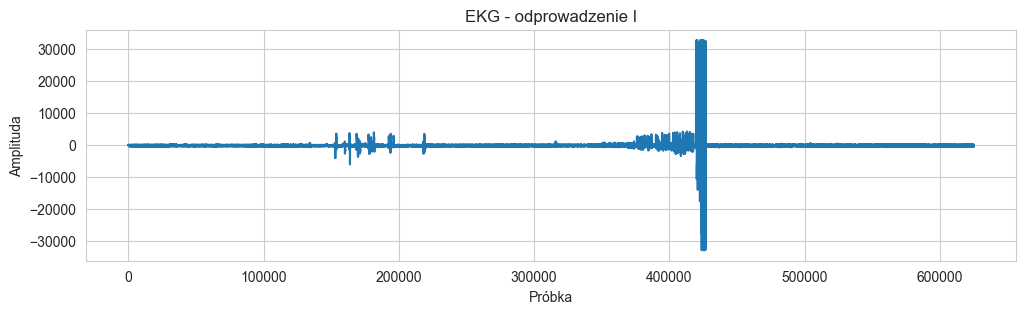

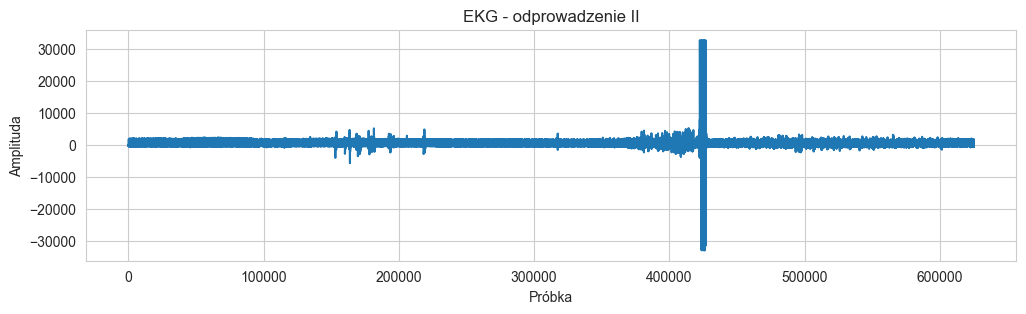

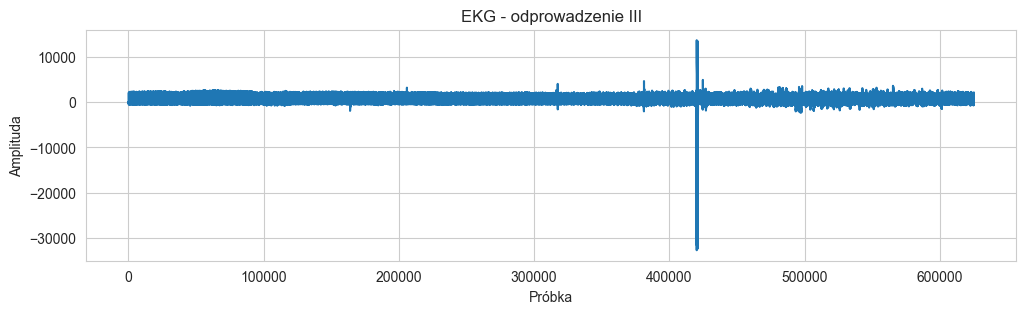

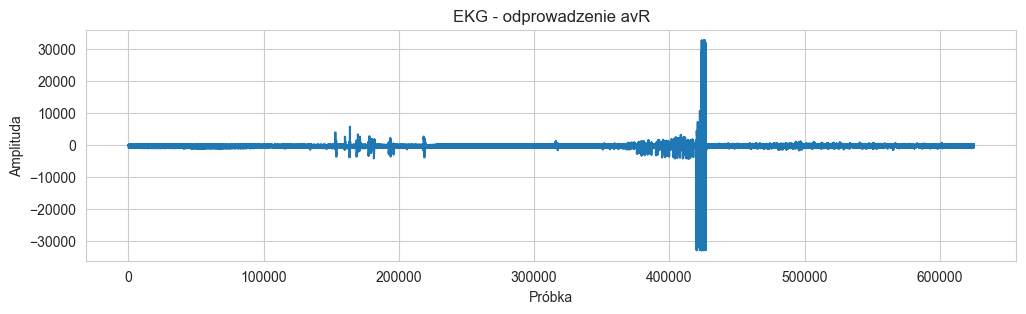

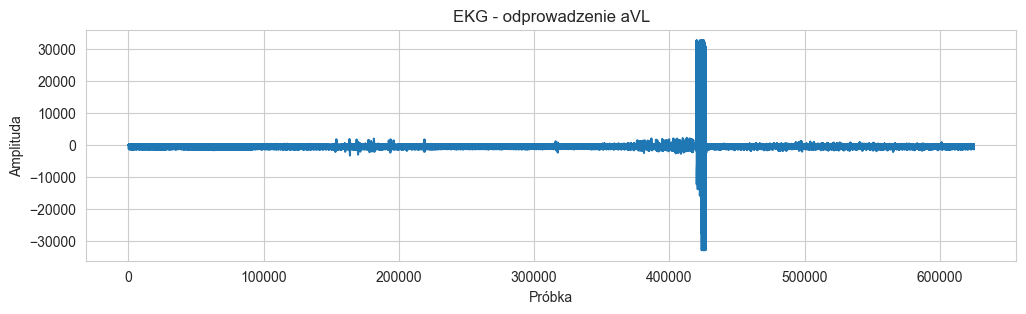

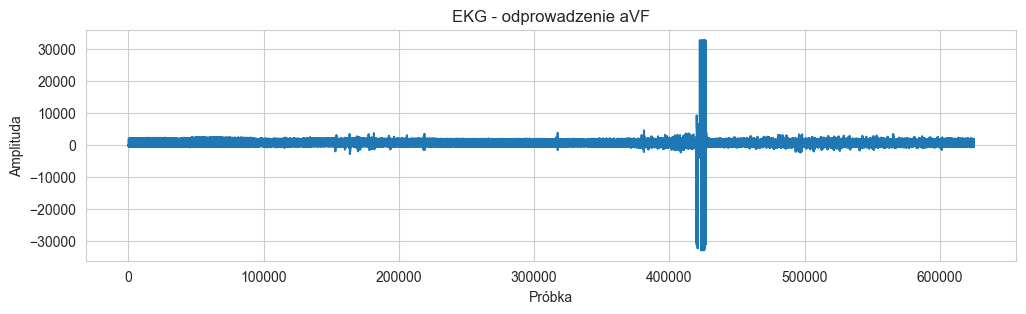

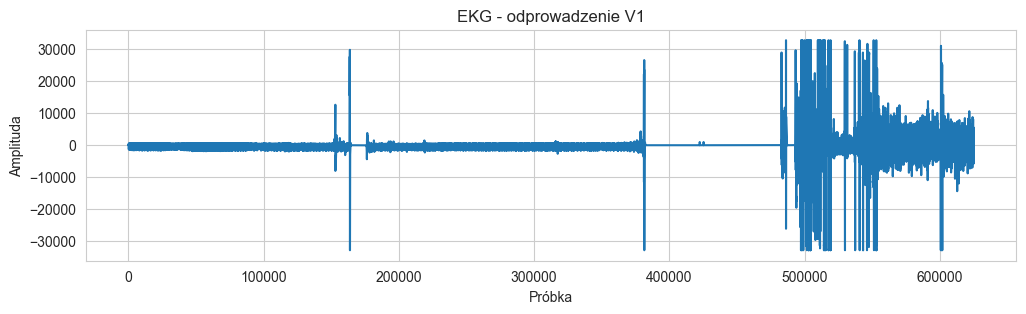

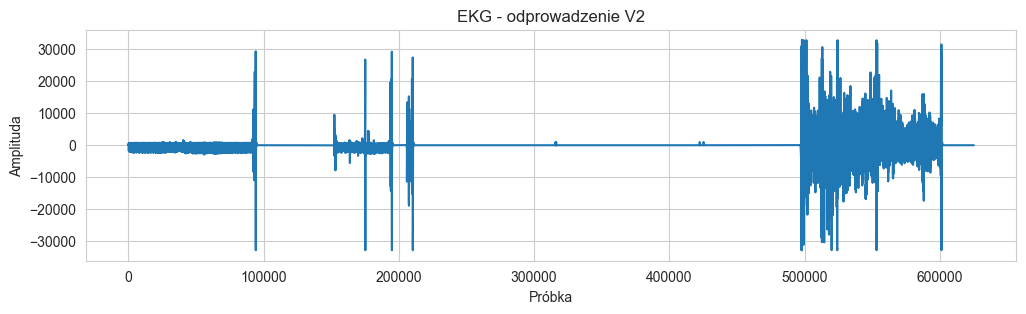

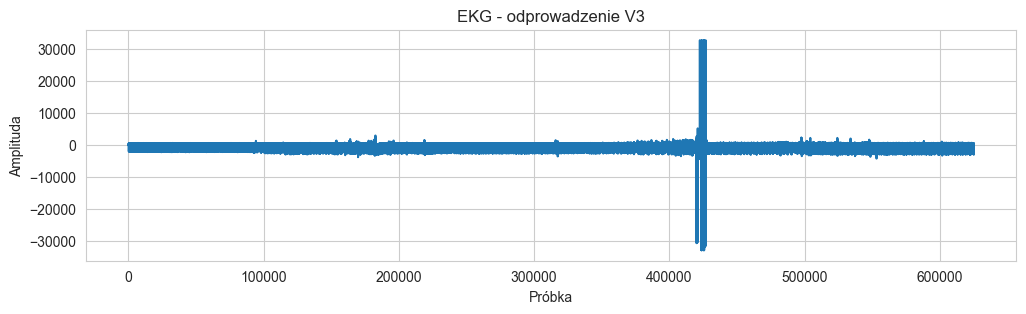

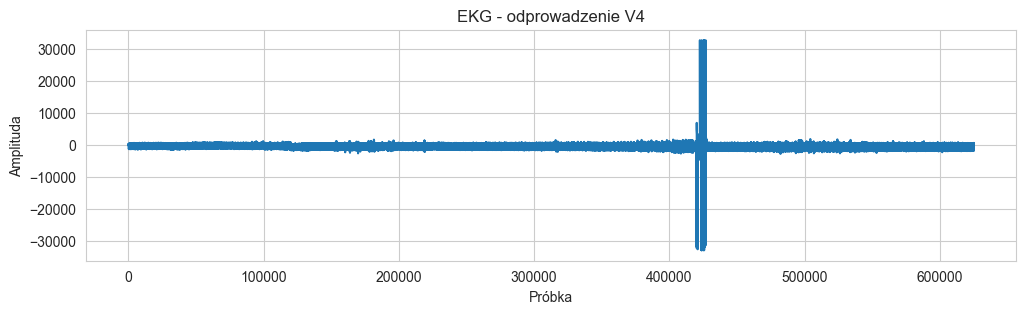

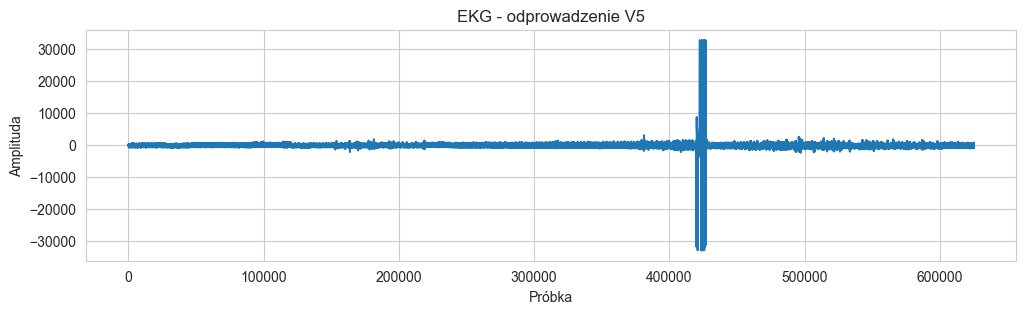

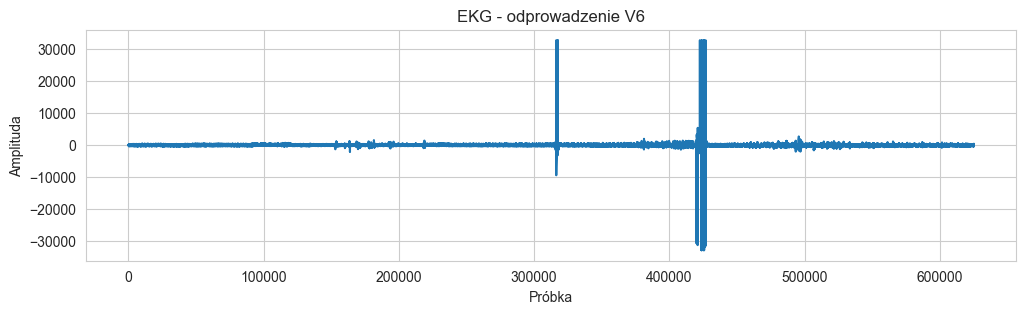

In [6]:
df = pd.read_csv("data/N38/N38_2025-2025-11-14-11-18-06.csv")
plot_ecg(df)

Jeśli zawęzimy zakres dla odprowadzeń V1 i V2 to możemy zauważyć, że dla sygnał znika, jest równy zero, kolejno w zakresach ok. 225000-480000 oraz 380000-480000.

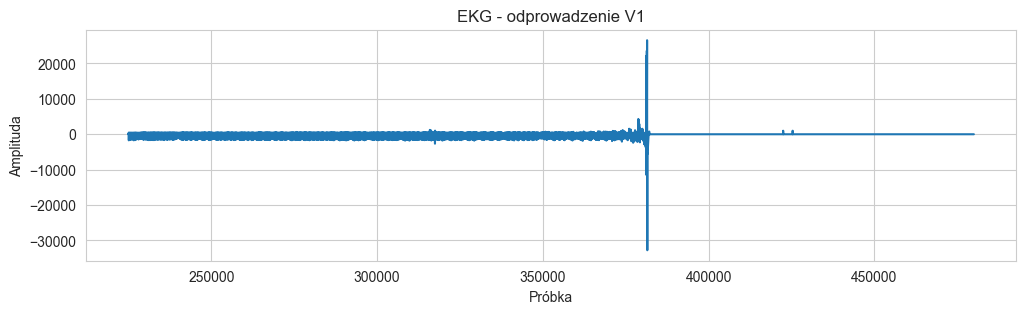

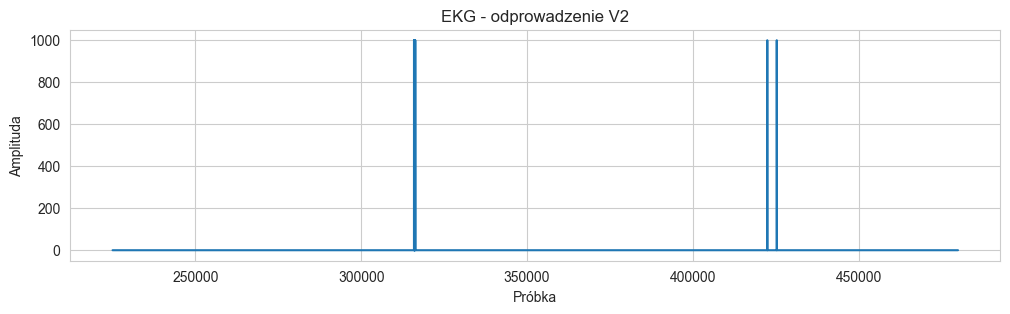

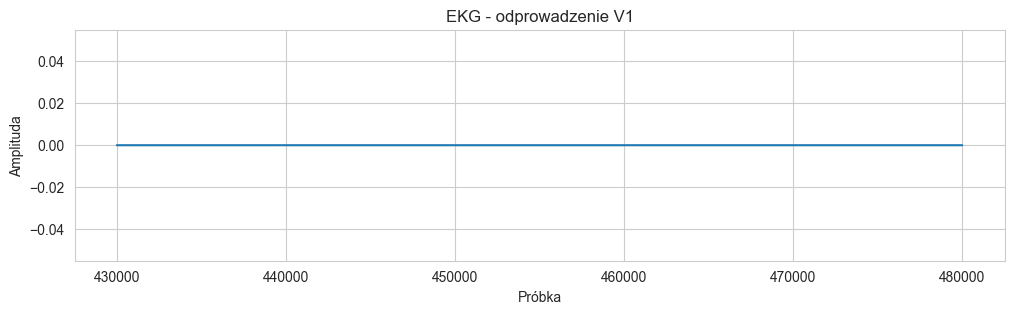

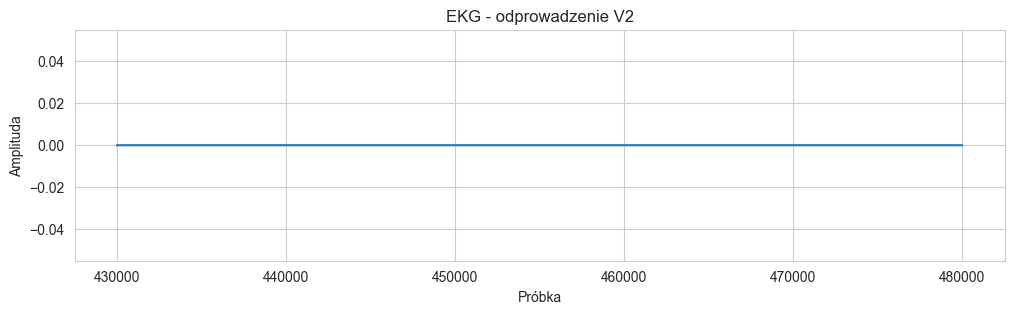

In [7]:
plot_ecg(df, columns=["V1", "V2"], start=225000, end=480000)
plot_ecg(df, columns=["V1", "V2"], start=430000, end=480000)

Ponadto możemy zauważyć również drift linii bazowej.

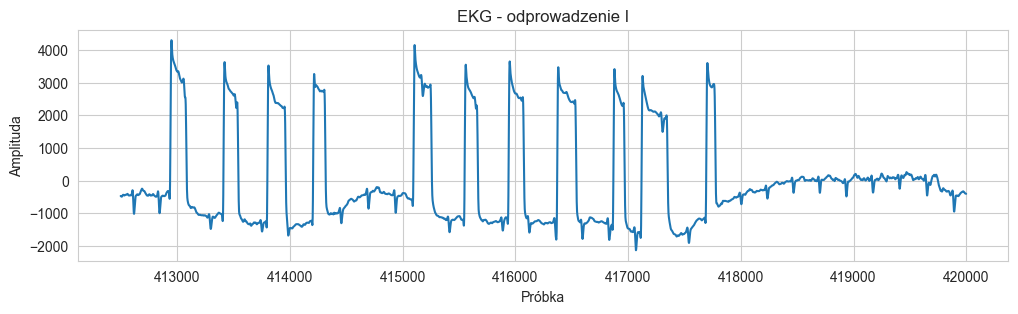

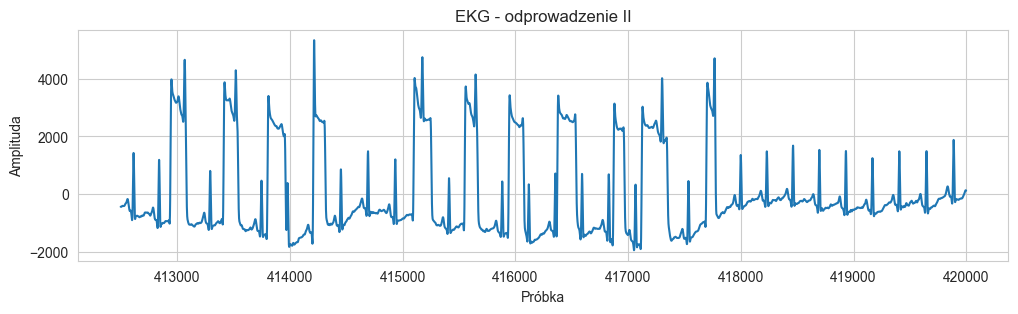

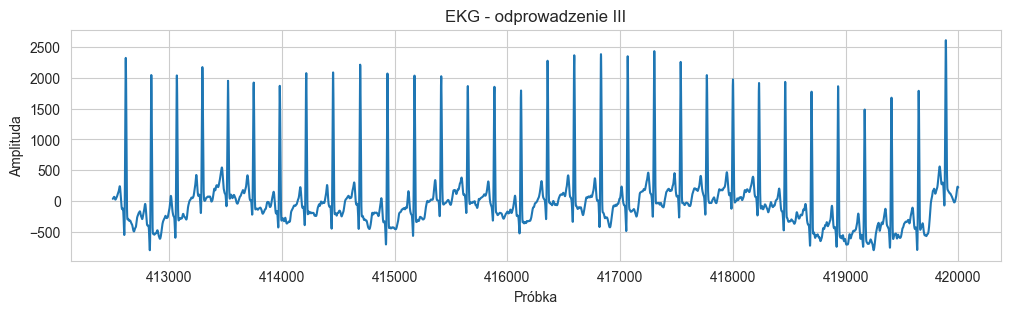

In [8]:
plot_ecg(df, start = 412500, end = 420000, columns = ["I", "II", "III"])

#### Przykłady z dużo mniejszą ilością zakłóceń.

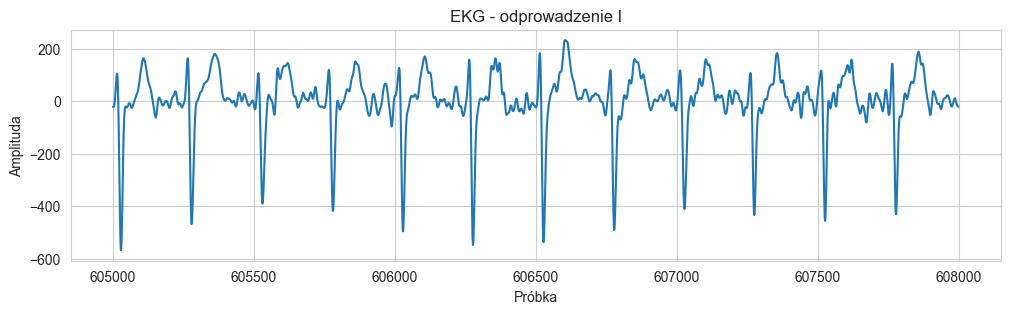

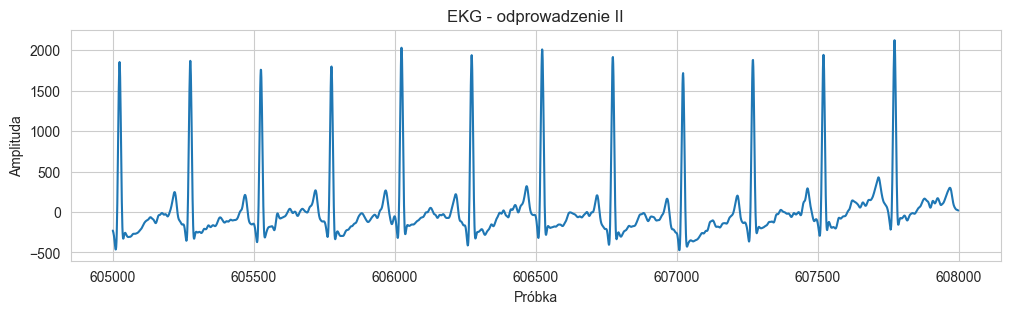

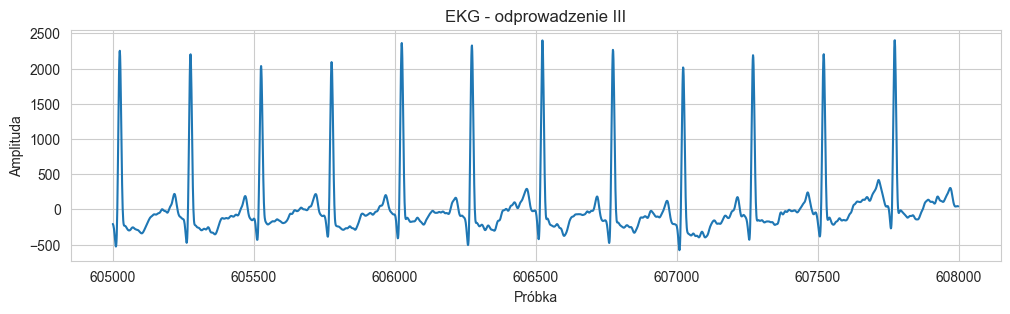

In [9]:
plot_ecg(df, start = 605000, end = 608000, columns = ["I", "II", "III"])

Poniżej przykład na początku badania w trakcie odpoczynku, gdzie dane nie zawierają wielu zakłóceń.

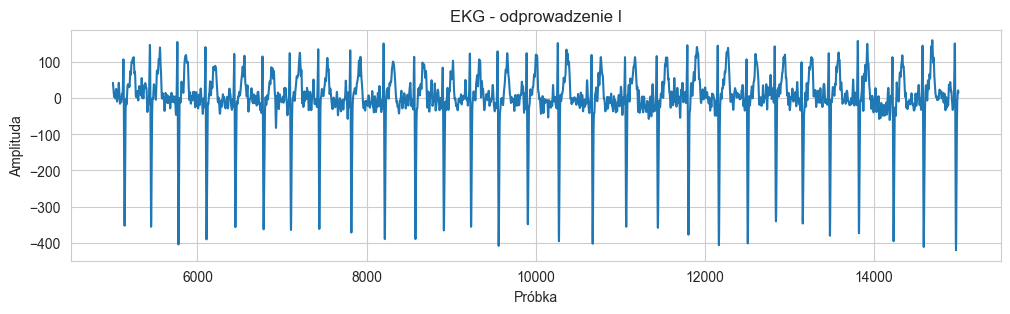

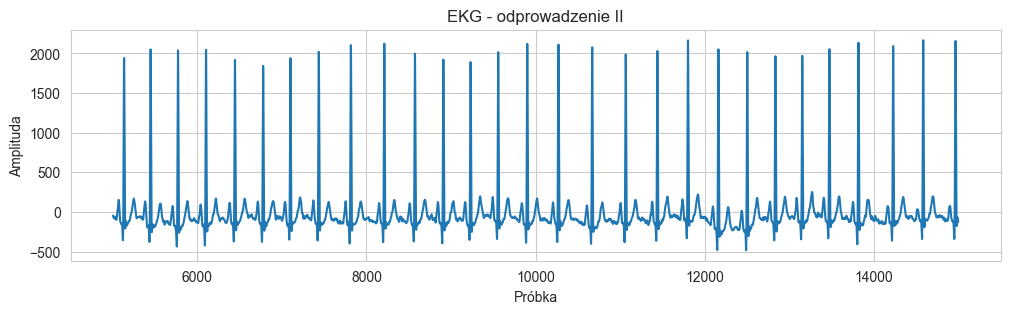

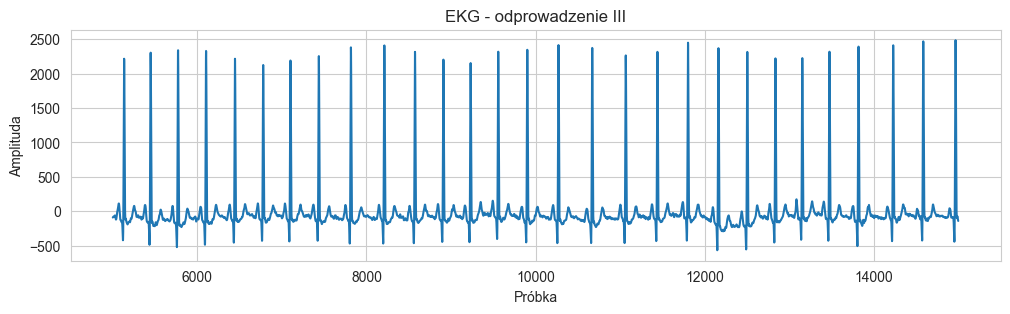

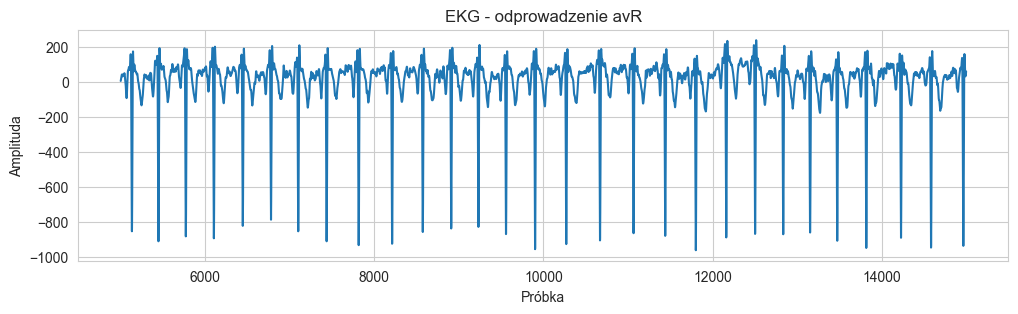

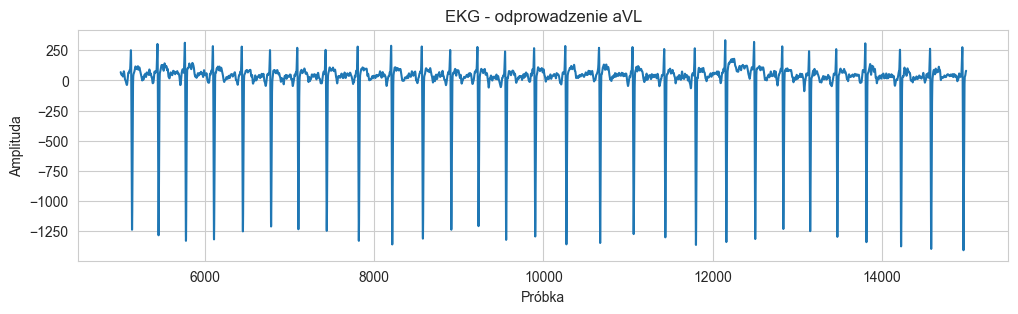

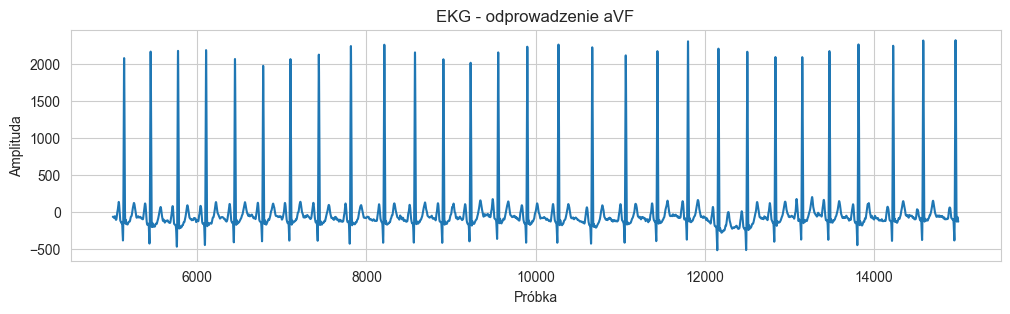

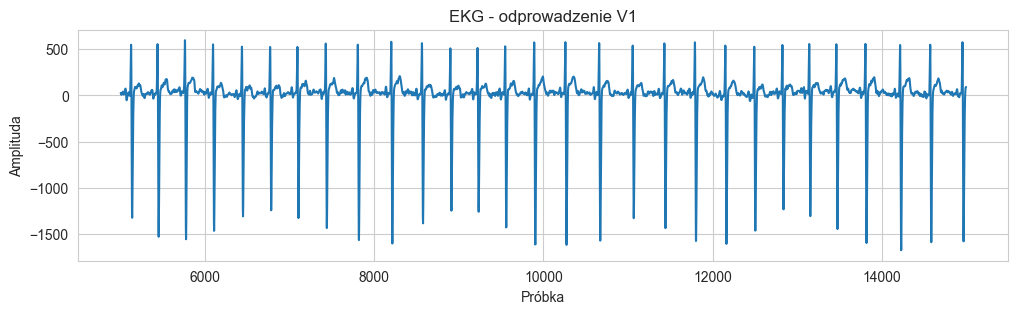

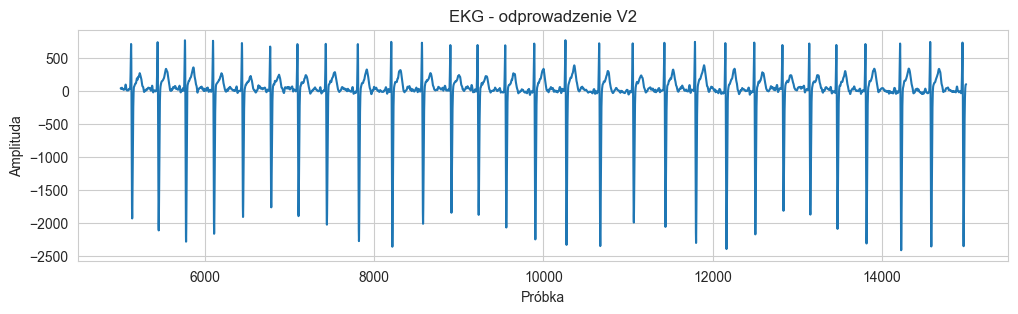

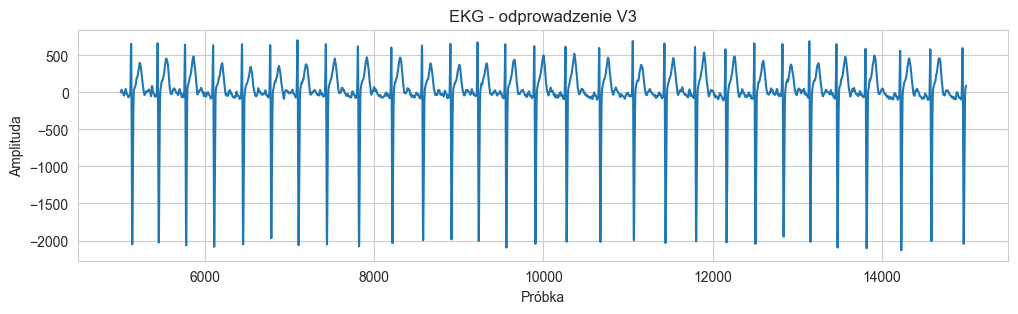

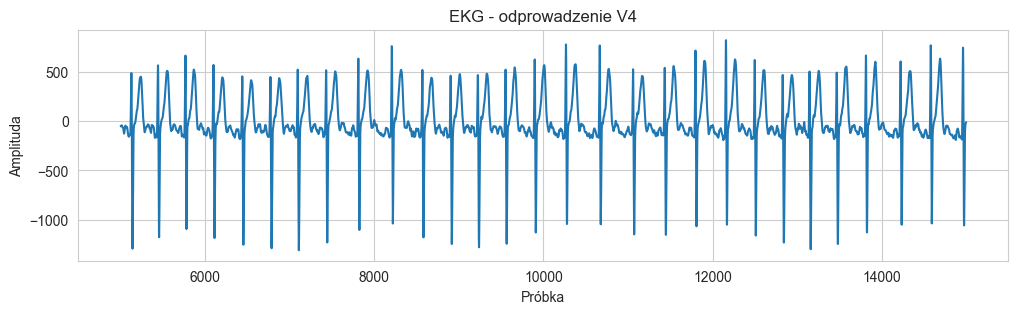

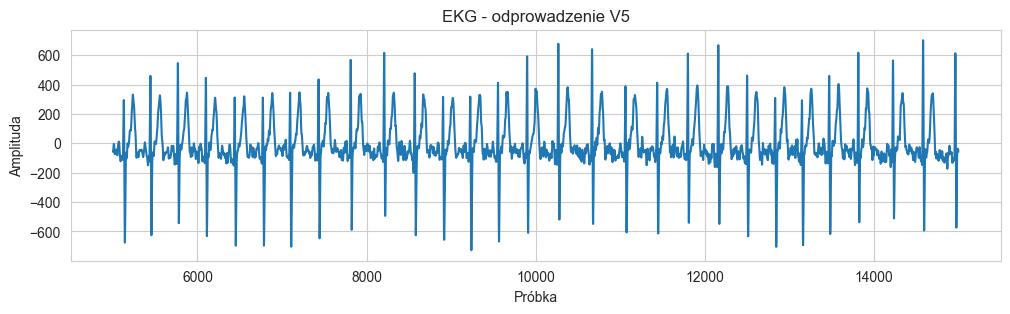

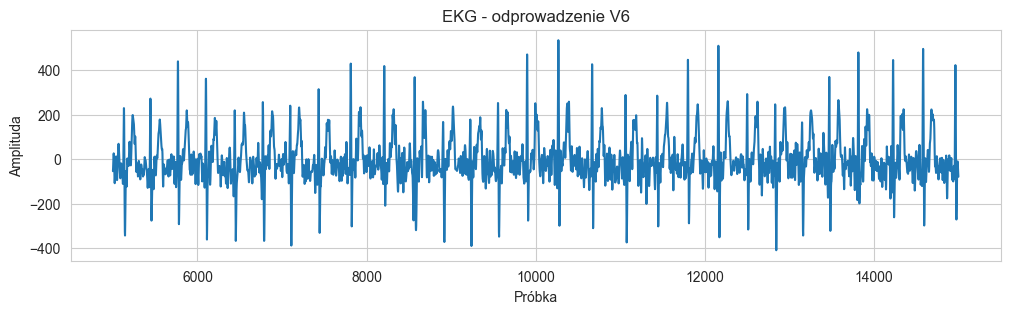

In [10]:
plot_ecg(df, start = 5000, end = 15000)

### Przykłady zakłóceń w sygnale z zegarka

W nagraniach z zegarka także pojawiają się fragmenty sygnału, które nie przypominają typowego przebiegu EKG – zarówno podczas spoczynku, jak i wysiłku fizycznego.

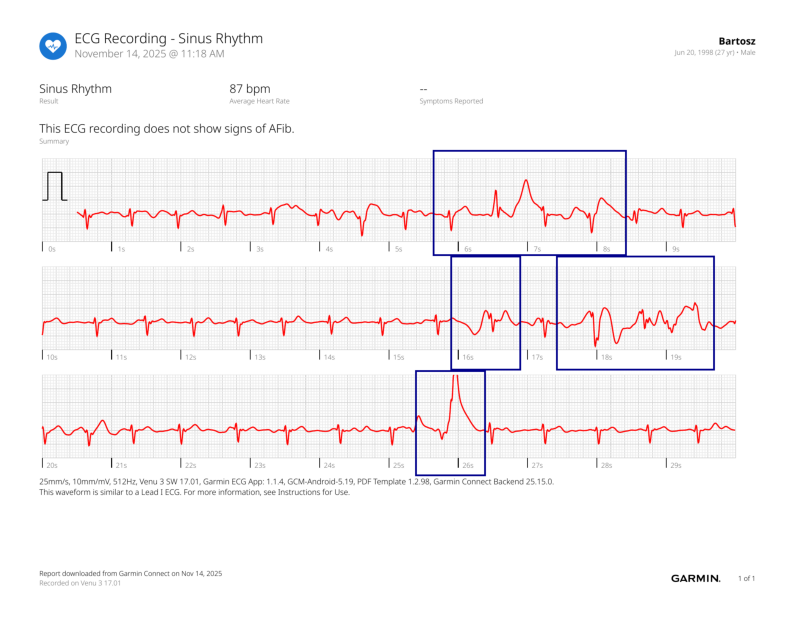

In [11]:
from pdf2image import convert_from_path
from PIL import ImageDraw

pages = convert_from_path("data/N38/GARMIN-PDFs/Garmin_ECGRecording_11142025_0910PM.pdf", dpi = 200)
page = pages[0]
draw = ImageDraw.Draw(page)
outline = "darkblue"
width = 5
draw.rectangle([1200, 400, 1750, 700], outline=outline, width=width)
draw.rectangle([1250, 700, 1450, 1025], outline=outline, width=width)
draw.rectangle([1550, 700, 2000, 1025], outline=outline, width=width)
draw.rectangle([1550, 700, 2000, 1025], outline=outline, width=width)
draw.rectangle([1150, 1025, 1350, 1325], outline=outline, width=width)

plt.figure(figsize=(10, 14))
plt.imshow(page)
plt.axis('off')
plt.show()

# Bibioteki

## Biblioteki do analizy danych i wizualizacji

- **NumPy**
  - Praca z tablicami i macierzami wielowymiarowymi
  - Operacje matematyczne i statystyczne
  - Podstawa dla większości bibliotek naukowych w Pythonie
- **Pandas**
  - Wczytywanie i manipulacja danymi w formie DataFrame
  - Filtrowanie, grupowanie, agregacje i czyszczenie danych
- **Matplotlib.pyplot**
  - Tworzenie wykresów i wizualizacji danych
  - Dostosowywanie osi, legend i stylu wykresów

## Biblioteki do przetwarzania sygnałów biomedycznych

### NeuroKit2

To pakiet w Pythonie przeznaczony do przetwarzania i analizy sygnałów biomedycznych, takich jak właśnie EKG. Oferuje on szereg narzędzi do filtrowania, wykrywania cech i wizualizacji sygnałów biomedycznych w sposób łatwy w obsłudze. Przykłady funkcji:

- **ecg_process** - uruchamia cały pipeline dla preprocessingu sygnału EKG
- **ecg_simulate** - tworzy sztuczne sygnały EKG o podanej długości i częstotliwości próbkowania
- **ecg_plot** - generuje wizualizacje
- **signal_findpeaks** - wykrywa peaki w sygnale

[NeuroKit - Functions - ECG](https://neuropsychology.github.io/NeuroKit/functions/ecg.html)

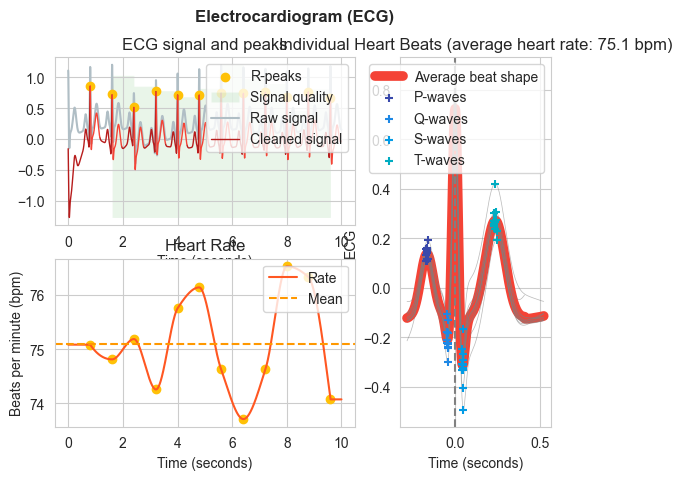

In [12]:
import neurokit2 as nk

ecg_sim = nk.ecg_simulate(duration=10, sampling_rate=500, heart_rate=75)
signals, info = nk.ecg_process(ecg_sim, sampling_rate=500)
nk.ecg_plot(signals, info)

### BioSPPy

Kolejna popularna biblioteka Python do analizy i przetwarzania różnych sygnałów biomedycznych. Próg wejścia jest nieco wyższy niż w NeuroKit2, ale oferuje ona większą kontrolę nad procesem analizy sygnałów.

[BioSPPy - Signals - ECG](https://biosppy.readthedocs.io/en/stable/biosppy.signals.html#biosppy-signals-ecg)

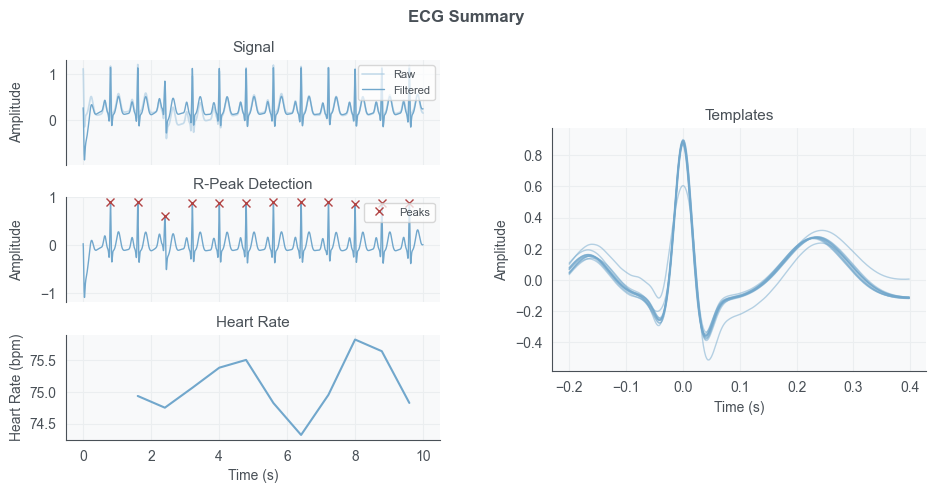

In [13]:
from biosppy.signals import ecg

out = ecg.ecg(signal=ecg_sim, sampling_rate=500, show=True)